In [54]:
%matplotlib inline

In [55]:
from pyshake.shakelib.source import Source
import numpy as np
import matplotlib.pyplot as plt
import StringIO
from openquake.hazardlib.gsim import base,abrahamson_2014
from openquake.hazardlib.geo import Mesh
from openquake.hazardlib.geo import point
from openquake.hazardlib.geo import utils
from openquake.hazardlib.geo.surface.planar import PlanarSurface
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neicio.gmt import GMTGrid
from mpl_toolkits.basemap import Basemap

In [56]:
def mycolorbar(mappable,ax=None,cax=None):
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(mappable,ax=ax, cax=cax)

In [57]:
def plotFault(fault):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth')
    for quad in fault.Quadrilaterals:
        P0,P1,P2,P3 = quad
        ax.plot([P0.longitude],[P0.latitude],[-P0.depth],'b.')
        ax.text(P0.longitude,P0.latitude,-P0.depth,'P0')
        ax.plot([P1.longitude],[P1.latitude],[-P1.depth],'b.')
        ax.text(P1.longitude,P1.latitude,-P1.depth,'P1')
        ax.plot([P2.longitude],[P2.latitude],[-P2.depth],'b.')
        ax.text(P2.longitude,P2.latitude,-P2.depth,'P2')
        ax.plot([P3.longitude],[P3.latitude],[-P3.depth],'b.')
        ax.text(P3.longitude,P3.latitude,-P3.depth,'P3')
        
        

In [58]:
fault_text = """
# Source: Wald, D. J., T. H. Heaton, and K. W. Hudnut (1996). The Slip History of the 1994 Northridge, California, Earthquake Determined from Strong-Motion, Teleseismic, GPS, and Leveling Data, Bull. Seism. Soc. Am. 86, S49-S70.
34.315 -118.421 5.000
34.401 -118.587 5.000
34.261 -118.693 20.427
34.175 -118.527 20.427
34.315 -118.421 5.000
"""
event_text = """<?xml version="1.0" encoding="US-ASCII" standalone="yes"?>
<earthquake id="blah" lat="34.213" lon="-118.537" mag="7.9" year="1994" month="01" day="17" hour="12" minute="30" second="55" timezone="GMT" depth="18.4" locstring="NORTHRIDGE" created="1211173621" otime="1210573681" type="" />
"""
source_text = """mech=RS"""
ffile = StringIO.StringIO(fault_text)
efile = StringIO.StringIO(event_text)
sfile = StringIO.StringIO(source_text)
source = Source.readFromFile(efile,faultfile=ffile,sourcefile=sfile)
gmpe = abrahamson_2014.AbrahamsonEtAl2014()
rupture = source.getRuptureContext(gmpe)
mapwidth = 2.0
latmin = rupture.hypo_lat - mapwidth
latmax = rupture.hypo_lat + mapwidth
lonmin = rupture.hypo_lon - mapwidth
lonmax = rupture.hypo_lon + mapwidth
dim = 0.02
lats = np.arange(latmin,latmax,dim)
lons = np.arange(lonmin,lonmax,dim)
lon,lat = np.meshgrid(lons,lats)
dep = np.zeros_like(lon)
mesh = Mesh(lon,lat,dep)
distances = source.getDistanceContext(gmpe,mesh)
rupture = source.getRuptureContext(gmpe)
for key in rupture.__slots__:
    try:
        value = eval('rupture.%s' % key)
    except:
        print 'No value set for %s' % key
        continue
    print '%s = %s' % (key,str(value))    


Reversing quad where dip not between 0 and 90 degrees.
Calculating method rx
Calculating method rjb
Calculating method ry0
Calculating method rrup
mag = 7.9
strike = 122.064089279
dip = 57.2464902838
rake = 90.0
ztor = 4.99999999988
hypo_lon = -118.537
hypo_lat = 34.213
hypo_depth = 18.4
width = 23.9369966838
No value set for hypo_loc


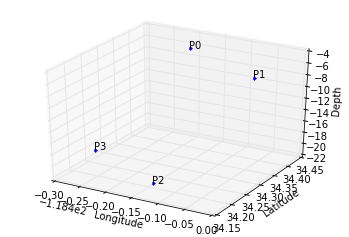

In [59]:
plotFault(source.Fault)

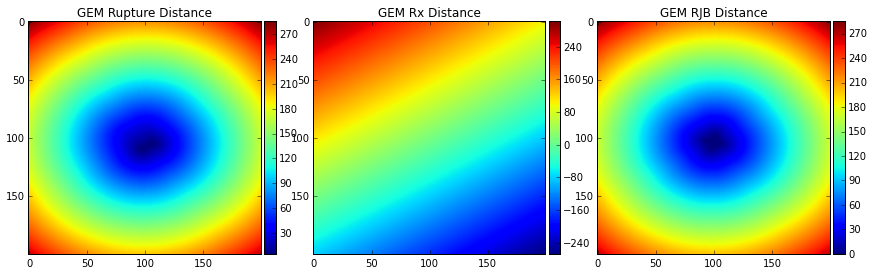

In [60]:
topLeft,topRight,bottomRight,bottomLeft = source.getQuadrilaterals()[0]
topRight.depth = topLeft.depth
bottomRight.depth = bottomLeft.depth

ps = PlanarSurface.from_corner_points(0.02,topLeft,topRight,bottomRight,bottomLeft)
rupdist = ps.get_min_distance(mesh)
rjbdist = ps.get_joyner_boore_distance(mesh)
rxdist = ps.get_rx_distance(mesh)
#rydist = ps.get_ry0_distance(mesh)

fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(12,6))
fig.tight_layout()
map1 = ax1.imshow(rupdist);mycolorbar(map1,ax=ax1);
ax1.set_title('GEM Rupture Distance');

map2 = ax2.imshow(rxdist);mycolorbar(map2,ax=ax2);
ax2.set_title('GEM Rx Distance');

map3 = ax3.imshow(rjbdist);mycolorbar(map3,ax=ax3);
ax3.set_title('GEM RJB Distance');

# plt.figure(figsize=(8,8)),
# plt.imshow(rydist);plt.colorbar();
# plt.title('GEM Ry0 Distance');

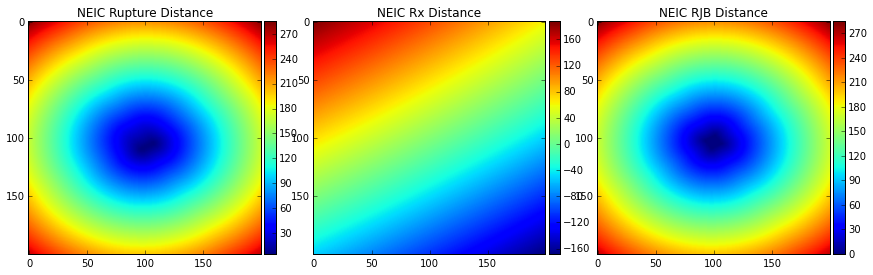

In [61]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(12,6))
fig.tight_layout()
map1 = ax1.imshow(distances.rrup);mycolorbar(map1,ax=ax1);
ax1.set_title('NEIC Rupture Distance');

map2 = ax2.imshow(distances.rx);mycolorbar(map2,ax=ax2);
ax2.set_title('NEIC Rx Distance');

map3 = ax3.imshow(distances.rjb);mycolorbar(map3,ax=ax3);
ax3.set_title('NEIC RJB Distance');

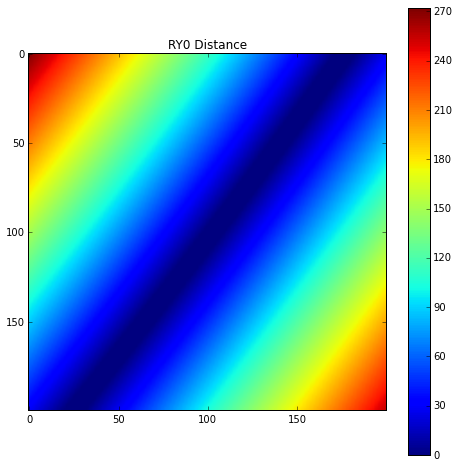

In [62]:
plt.figure(figsize=(8,8))
plt.imshow(distances.ry0)
plt.title('RY0 Distance')
plt.colorbar();

In [63]:
rupture = source.getRuptureContext(gmpe)
for key in rupture.__slots__:
    try:
        value = eval('rupture.%s' % key)
    except:
        print 'No value set for %s' % key
        continue
    print '%s = %s' % (key,str(value))

mag = 7.9
strike = 122.064089279
dip = 57.2465491413
rake = 90.0
ztor = 4.99999999988
hypo_lon = -118.537
hypo_lat = 34.213
hypo_depth = 18.4
width = 23.9369966838
No value set for hypo_loc


In [64]:
rxgrid = GMTGrid()
rxgrid.geodict = {'xmin':lonmin,'xmax':lonmax,
                 'ymin':latmin,'ymax':latmax,
                 'xdim':dim,'ydim':dim,
                  'ncols':distances.rx.shape[1],'nrows':distances.rx.shape[1]}
rxgrid.griddata = distances.rx

In [65]:
def mapDistance(ax,lon,lat,dist,quads,tstr):
    xmin = lon.min()
    xmax = lon.max()
    ymin = lat.min()
    ymax = lat.max()
    m = Basemap(llcrnrlon=xmin,llcrnrlat=ymin,urcrnrlon=xmax,urcrnrlat=ymax,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='h',area_thresh=1000.,projection='lcc',\
            lat_1=lat.mean(),lon_0=lon.mean(),ax=ax)
    # draw coastlines and political boundaries.
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    pmesh = m.pcolormesh(lon,lat,dist,latlon=True)
    plt.hold(True)
    ax.set_title(tstr)
    m.colorbar(pmesh)
    for quad in quads:
        P0,P1,P2,P3 = quad
        qx = [P0.longitude,P1.longitude,P2.longitude,P3.longitude,P0.longitude]
        qy = [P0.latitude,P1.latitude,P2.latitude,P3.latitude,P0.latitude]
        m.plot(qx,qy,latlon=True,color='pink') 

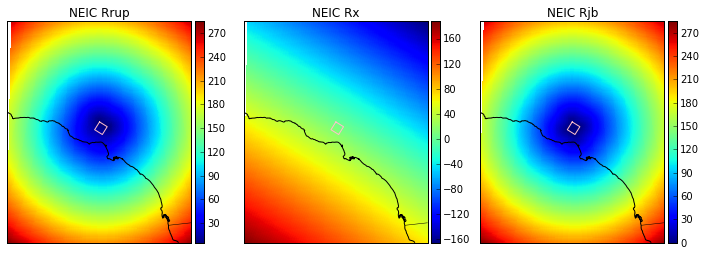

In [66]:
quads = source.Fault.getQuadrilaterals()
fig,(ax0,ax1,ax2) = plt.subplots(nrows=1,ncols=3,figsize=(12,6))
mapDistance(ax0,lon,lat,distances.rrup,quads,'NEIC Rrup')
mapDistance(ax1,lon,lat,distances.rx,quads,'NEIC Rx')
mapDistance(ax2,lon,lat,distances.rjb,quads,'NEIC Rjb')

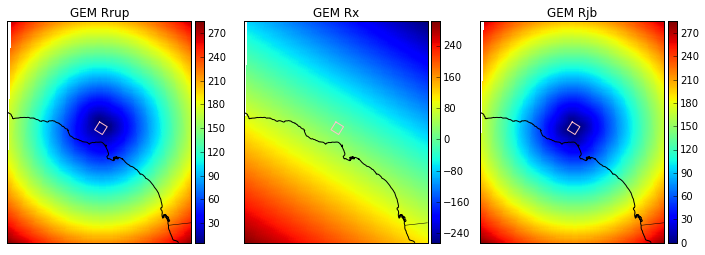

In [67]:
fig,(ax0,ax1,ax2) = plt.subplots(nrows=1,ncols=3,figsize=(12,6))
mapDistance(ax0,lon,lat,rupdist,quads,'GEM Rrup')
mapDistance(ax1,lon,lat,rxdist,quads,'GEM Rx')
mapDistance(ax2,lon,lat,rjbdist,quads,'GEM Rjb')